In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir

In [2]:
def update_progress(progress):
    ''' A simple function updating the time progress. 
    Inspired by 
    http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console 
    Parameters
    -----------
    progress : a value (float or int) between 0 and 100 indicating 
               percentage progress 
    Returns
    ----------
    None
    '''
    print '\r[%-10s] %0.2f%%' % ('#' * int(progress/10), progress),

## Initial sample of CRTS stars from Branimir ... 

First, find out the total number of objects to start with .. stars_CRTS/0/

In [3]:
pwd

u'/local/tmp/suberlak/CRTS_PROJECT/code'

In [4]:
dir_in = '../raw_LC_CRTS/stars/'

# make sure that we only take   stellar lightcurves,  which always end with .dat 
# and ignore two other files which may be there  : 
# radec.00   and file.list

stars_list  = []
for f in listdir(dir_in) : 
    if f.endswith('.dat'):
        stars_list.append(f)
        
        


In [5]:
print('We have %d stars to start with ' % len(stars_list))

We have 52131 stars to start with 


## Remove empty files and those with less than 10 points 

In [7]:
c = 0 
empty_files = np.zeros(len(stars_list), dtype='bool')
for i in range(len(stars_list)):
    obj = stars_list[i]
    address = dir_in + obj
    f = open(address, 'r')
    if f.readline() == '' :
        c += 1
        empty_files[i] = True 
        
print('We have %d empty files' % c)   

We have 1410 empty files


In [8]:
stars_nonempty = np.array(stars_list)[~empty_files]
len(stars_nonempty)

50721

Remove those files that have less than 10 points : 

In [10]:
c = 0 
short_files  = np.zeros(len(stars_nonempty), dtype='bool')
for i in range(len(stars_nonempty)):
    obj = stars_nonempty[i]
    num_lines = sum(1 for line in open(dir_in+obj))
    if num_lines < 10 :
        c += 1
        short_files[i] = True
        
print('We have %d  files with less than 10 pts ' % c) 

We have 1336  files with less than 10 pts 


In [11]:
stars_10_pts_plus = stars_nonempty[~short_files]
len(stars_10_pts_plus)

49385

## Preprocessing :  Day-averaged lightcurves : remove those with less than 10 days 

 ### : needs be RUN ONLY ONCE  to make them! (takes about 10 mins on the workstation)

Make day-averaged lightcurves, save only if more than 10 observing days (points in the day-averaged light curve). 
Save MJD, avg_mag, error, N_obs that day.

In [12]:
# code based on the stars_crts_preprocessing.py 
# and QSO_CRTS_day_averaged_stats.py
dir_in = '../raw_LC_CRTS/stars/'
dir_out = '../proc_LC_CRTS/stars/'

lc_files  = stars_10_pts_plus


k = 0
total = float(len(lc_files))

for obj in lc_files:
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_in+obj
    data=np.loadtxt(address)
    
    averages=np.zeros(shape=(len(data),3))

    mjd = data[:,0]
    mags = data[:,1]
    errs = data[:,2]
   
    days = np.unique([int(day) for day in data[:,0]])
    
    # storage arrays  for each qso (all N's)
    mjd_arr = np.zeros_like(days).astype(float)
    avg_mags = np.zeros_like(days).astype(float)
    avg_err_weights = np.zeros_like(days).astype(float)  
    Nobs = np.zeros_like(days).astype(float)

    # loop through days calculating mean, etc. 
    for i in range(len(days)):
        day = days[i]
        int_mjd = np.require(mjd,int)       # forcing mjd array -> integers
        condition = (int_mjd == day)        # finding where int(mjd) = day
        N = float(len(mags[condition]))            # number of obs in that night 
        Nobs[i] = N
        w=1.0 / ( errs[condition] * errs[condition]) 
        
        # daily error-weighted mean 
        avgmag = np.average(mags[condition], weights = w)
        avg_mags[i] = avgmag
        #avgmag = np.average(mags[condition],weights=errs[condition]) # works for single measurement too ! 
        
        # error based on inverse square of sum of weights 
        error_weights = 1.0 / np.sqrt(np.sum(w))
        
        # increase error if too small 
        if error_weights < 0.02 : 
            error_weights = np.sqrt(error_weights**2.0 + 0.01**2.0)  
            
        avg_err_weights[i] = error_weights
      
        mjd_arr[i] = np.mean(mjd[condition])
        
    # Save the output... 
    # Once per lightcurve 
    # ONLY IF THERE IS MORE THAN 10 OBS ! 
    
    if( len(mjd_arr) >  10 ) :
        name_out = dir_out + 'out_'+obj[:18]+'.txt'
        np.savetxt(name_out, np.column_stack((mjd_arr,avg_mags, avg_err_weights, Nobs)),fmt='%11.4f')

        
    

[######### ] 99.00%


How many stars with LC  longer than 10 days we have  ? 

In [13]:
stars_LC_proc_err_w = listdir(dir_out)

In [14]:
len(stars_LC_proc_err_w)

48250

Calculate the stats of that sample : 
    
    

In [17]:
def compare_star_LC(i=None, n=None):
    '''A short function to plot an original stellar LC from CRTS (before all averaging, etc)
    to the day-averaged LC.
    
    Parameters: 
    -----------
    i = a number of the stellar processed LC in the stars_CRTS_LC_err_w/  dir 
     or  
    n = name of an original stellar LC , eg . '127648.dat' 
    Returns:
    --------
    None
    '''
    
    dir_in = '../raw_LC_CRTS/stars/'
    dir_out = '../proc_LC_CRTS/stars/'
    stars_LC_10_days_plus= listdir(dir_out)
    if n ==None : 
        star_name_proc = stars_LC_10_days_plus[i]
    else :
        star_name_proc = 'out_'+ n +'.txt'
   
    orig_star_name = star_name_proc[4:-4]


    data = np.loadtxt(dir_out  + star_name_proc)
    data_orig = np.loadtxt(dir_in + orig_star_name)
    
    mjd_arr,avg_mags, avg_err_weights, Nobs = data[:,0], data[:,1], data[:,2], data[:,3]
    mjd,mags, errs = data_orig[:,0],data_orig[:,1], data_orig[:,2]
 

    %matplotlib inline

    fig, axs = plt.subplots(2,2, figsize=(16,10))
    ax = np.ravel(axs)
    ax[0].set_title('Original LC for '+orig_star_name)
    ax[0].scatter(mjd,mags)
    ax[0].errorbar(mjd, mags, errs, linestyle='None')
    print 'Vertical dashed lines indicate individual obs days '

    for day in days : 

        ax[0].axvline(day, ymin=0, ymax=0.2, lw =1, ls = '--', color='red')


    ax[1].set_title('Day-averaged LC for '+ orig_star_name)
    ax[1].scatter(mjd_arr,avg_mags, color='green')
    ax[1].errorbar(mjd_arr, avg_mags, avg_err_weights, linestyle='None', color='green')
    
    ax[2].set_title('Original and avg  LC for '+orig_star_name)
    ax[2].scatter(mjd,mags, alpha=0.5)
    ax[2].errorbar(mjd, mags, errs, linestyle='None',alpha=0.5)
    ax[2].scatter(mjd_arr,avg_mags,alpha=0.5, color='red')
    ax[2].errorbar(mjd_arr, avg_mags, avg_err_weights, linestyle='None', color='red')
    ax[3].axis('off')
    plt.show()

Vertical dashed lines indicate individual obs days 


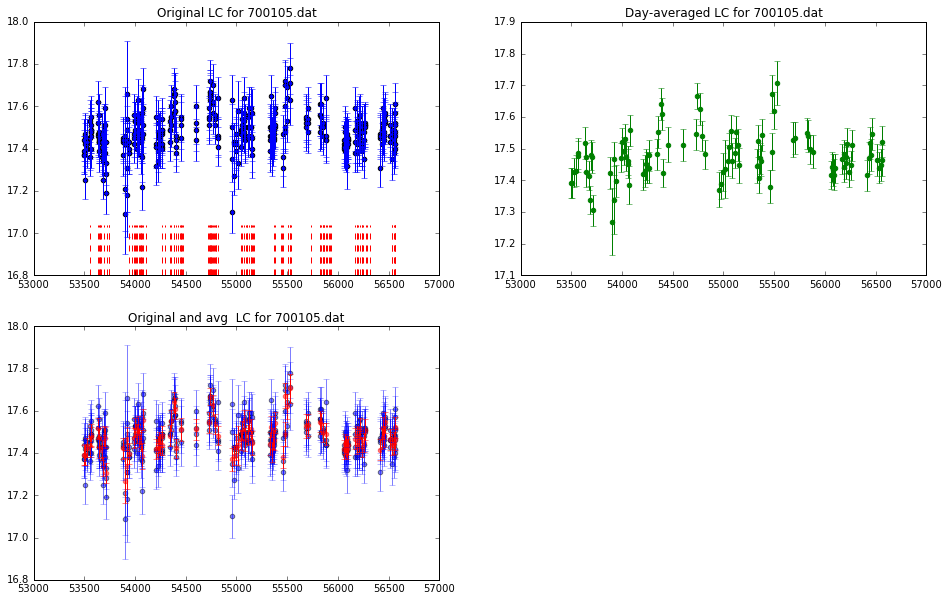

In [18]:
compare_star_LC(2)

Looks like the day-averaging is working fine.  Now , calculate the statistics for the day-averaged stars (takes about 3 mins on the workstation)

In [19]:
from collections import OrderedDict
dir_in = '../raw_LC_CRTS/stars/'
dir_out = '../proc_LC_CRTS/stars/'

stars_LC_10_days_plus = []
for file in listdir(dir_out) : 
    if file.endswith('.txt'):
        stars_LC_10_days_plus.append(file)

stats_proc_err_w = OrderedDict()
keys = ['avg_mag', 'med_mag', 'avg_err', 'med_err', 'name', 'avg_err_90th_percentile']
for key in keys: 
    stats_proc_err_w[key] = [] 


k = 0
total = float(len(lc_files))

for i in range(len(stars_LC_10_days_plus)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    star_name_proc = stars_LC_10_days_plus[i]
    orig_star_name = star_name_proc[4:-4]


    data = np.loadtxt(dir_out  + star_name_proc)
    #data_orig = np.loadtxt(dir_in + orig_star_name)

    mjd_arr,avg_mags, avg_err_weights, Nobs = data[:,0], data[:,1], data[:,2], data[:,3]
    #mjd,mags, errs = data_orig[:,0],data_orig[:,1], data_orig[:,2]

    # Calculate stats for day-averaged stars 
    stats_proc_err_w['avg_mag'].append(np.mean(avg_mags))
    stats_proc_err_w['med_mag'].append(np.median(avg_mags))
    stats_proc_err_w['avg_err'].append(np.mean(avg_err_weights))
    stats_proc_err_w['med_err'].append(np.median(avg_err_weights))
    stats_proc_err_w['name'].append(orig_star_name)
    stats_proc_err_w['avg_err_90th_percentile'].append(np.percentile(avg_err_weights , 90))
    


[######### ] 97.00%


In [20]:
len(stars_LC_10_days_plus)

48250

In [22]:
np.median(stats_proc_err_w['avg_err'])

0.090505061115355223

Note : in my old work (in SDSS_CRTS directory) you will find that there is an entire issue about filtered vs unfiltered lightcurves. This is because in the code I used in 2014 and mid-2015, I had in processing of stellar lightcurves a line that wwas supposed to filter out some stars with high error, but it did not work as expected. Thus I redid the processing, to figure out what went wrong, and it's not immediately obvious what the filter  actually did. Nevertheless, for the poster in January 2016 I used a re-processed version of stellar lightcurves from CRTS. If you would like to filter out any outliers from stelalr lightcurves, it can always be done at the later stage, just before taking the individual master files...  

In [31]:
stats_proc_err_w.keys()

['avg_mag', 'med_mag', 'avg_err', 'med_err', 'name', 'avg_err_90th_percentile']

(array([ 19413.,   8727.,   3746.,   2551.,   2397.,   2362.,   2620.,
          4413.,   1955.,     66.]),
 array([ 0.02325 ,  0.083025,  0.1428  ,  0.202575,  0.26235 ,  0.322125,
         0.3819  ,  0.441675,  0.50145 ,  0.561225,  0.621   ]),
 <a list of 10 Patch objects>)

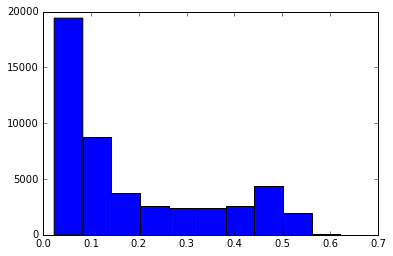

In [32]:
%matplotlib inline
plt.hist(stats_proc_err_w['avg_err_90th_percentile'])

In [28]:
min(stats_proc_err_w['avg_err'])

0.023456250000000001